## CSCI 470 Activities and Case Studies

1. For all activities, you are allowed to collaborate with a partner. 
1. For case studies, you should work individually and are **not** allowed to collaborate.

By filling out this notebook and submitting it, you acknowledge that you are aware of the above policies and are agreeing to comply with them.

Some considerations with regard to how these notebooks will be graded:

1. You can add more notebook cells or edit existing notebook cells other than "# YOUR CODE HERE" to test out or debug your code. We actually highly recommend you do so to gain a better understanding of what is happening. However, during grading, **these changes are ignored**. 
2. You must ensure that all your code for the particular task is available in the cells that say "# YOUR CODE HERE"
3. Every cell that says "# YOUR CODE HERE" is followed by a "raise NotImplementedError". You need to remove that line. During grading, if an error occurs then you will not receive points for your work in that section.
4. If your code passes the "assert" statements, then no output will result. If your code fails the "assert" statements, you will get an "AssertionError". Getting an assertion error means you will not receive points for that particular task.
5. If you edit the "assert" statements to make your code pass, they will still fail when they are graded since the "assert" statements will revert to the original. Make sure you don't edit the assert statements.
6. We may sometimes have "hidden" tests for grading. This means that passing the visible "assert" statements is not sufficient. The "assert" statements are there as a guide but you need to make sure you understand what you're required to do and ensure that you are doing it correctly. Passing the visible tests is necessary but not sufficient to get the grade for that cell.
7. When you are asked to define a function, make sure you **don't** use any variables outside of the parameters passed to the function. You can think of the parameters being passed to the function as a hint. Make sure you're using all of those variables.
8. Finally, **make sure you run "Kernel > Restart and Run All"** and pass all the asserts before submitting. If you don't restart the kernel, there may be some code that you ran and deleted that is still being used and that was why your asserts were passing.

# Model Interpretability

In this exercise you'll use the [alibi](https://docs.seldon.io/projects/alibi/en/stable/) library to explain why some models make the predictions they do.

In [1]:
! pip install alibi

     |████████████████████████████████| 317kB 7.6MB/s 
     |████████████████████████████████| 28.0MB 152kB/s 
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052145 sha256=6f1d4fe4eec341f46b56772fd47e8bdc6be1e372596e11587b08e31de6e6a1f5
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built spacy-lookups-data


In [2]:
import sklearn
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [3]:
data = load_iris()

In [4]:
print(data["DESCR"])
features = data["data"]
targets = data["target"]

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [5]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=0)

In [6]:
print(len(X_test))

38


In [7]:
## Create 2 classifiers: rf_clf that is a Random Forest model, and svm_clf that is a Linear SVM model
## Train them both on the training data
## Use them to predict the test data - saving it to y_rf_pred and y_svm_pred respectively
## You may consider using GridSearchCV to determine a hyperparameter search for both models.

rf_clf = RandomForestClassifier() 
svm_clf = LinearSVC()
rf_clf.fit(X_train,y_train)
svm_clf.fit(X_train,y_train)
y_rf_pred = rf_clf.predict(X_test)
y_svm_pred = svm_clf.predict(X_test)

# raise NotImplementedError()

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [8]:
assert len(y_rf_pred) == 38
assert isinstance(rf_clf, RandomForestClassifier) or isinstance(rf_clf, GridSearchCV)
assert len(y_svm_pred) == 38
assert isinstance(svm_clf, LinearSVC) or isinstance(svm_clf, GridSearchCV)

In [9]:
print(f"The random forest model achieved an accuracy of {accuracy_score(y_test, y_rf_pred)}.")
print(f"The support vector machine model achieved an accuracy of {accuracy_score(y_test, y_svm_pred)}.")

The random forest model achieved an accuracy of 0.9736842105263158.
The support vector machine model achieved an accuracy of 0.9210526315789473.


In [10]:
# Since we used a Linear SVM, we can easily determine the coefficients for the features:
if isinstance(svm_clf, LinearSVC):
    print(svm_clf.coef_)
elif isinstance(svm_clf, GridSearchCV):
    print(svm_clf.best_estimator_.coef_)

print("Each class gets a coefficient for each feature that helps us determine that feature's importance.")

[[ 0.21779162  0.39842467 -0.83300946 -0.41992492]
 [ 0.02775347 -0.79171708  0.39194034 -0.92000737]
 [-1.08578219 -0.7819398   1.61120675  1.50151237]]
Each class gets a coefficient for each feature that helps us determine that feature's importance.


Now let's look at how we can use explainers, namely the [AnchorTabular](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html#id3) explainer to understand why the models make the predictions they do.

In [11]:
from alibi.explainers import AnchorTabular

Alibi explainers follow a general structure of:

1. Initialize the explainer, providing a prediction function, and explainer specific parameters. `exp = Explainer(predict_func, param_1, param_2, ...)`
1. Fit the explainer to the training data (this step is explainer dependent) `exp.fit(train_data)`
1. Explain a given sample `exp.explain(sample)`

First, we reframe the prediction pipeline into a prediction function that we can use with the explainer:

In [12]:
rf_clf_func = lambda x: rf_clf.predict(x)
svm_clf_func = lambda x: svm_clf.predict(x)

Now we can instantiate the explainer using the prediction function and any parameters the explainer requires:

In [13]:
rf_explainer = AnchorTabular(rf_clf_func, data["feature_names"])
rf_explainer.fit(X_train)

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'disc_perc': (25, 50, 75), 'seed': None}}
)

In [14]:
svm_explainer = AnchorTabular(svm_clf_func, data["feature_names"])
svm_explainer.fit(X_train)

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'disc_perc': (25, 50, 75), 'seed': None}}
)

Once the explainer is set up, we can now use it to `.explain` samples! Pick a sample below to explain the two models' predictions.

In [15]:
# Change this value to choose a test sample
index_to_explain = 20


rf_explanation = rf_explainer.explain(X_test[index_to_explain])
svm_explanation = svm_explainer.explain(X_test[index_to_explain])

In [16]:
rf_explanation.anchor, rf_explanation.precision

(['petal length (cm) > 4.25', 'petal width (cm) > 1.90'], 0.9967105263157895)

In [17]:
svm_explanation.anchor, svm_explanation.precision

(['petal width (cm) > 1.90', 'petal length (cm) > 4.25'], 1.0)

Here we can see what the model's explanation for the classification of that sample is. You can see that even with our relatively interpretable model of Linear SVMs, these explainers can provide a more direct and intuitive explanation for why a sample was labeled the way it was.

Now that you've seen the general approach for these explainers, let's work on something a bit more complex. Now you'll have to create the models, the prediction function, and the explainers.

## Explaining MNIST predictions

Explaining data from measured observations is simple enough. Now let's try explaining how images get labeled.

In [18]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [19]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [20]:
sample_index = 12
sample = x_train[sample_index]

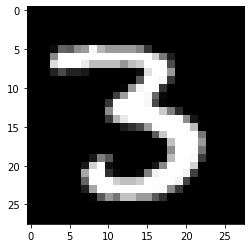

In [21]:
plt.imshow(sample, cmap="gray")

In [22]:
## Create a neural network model that should do well on the MNIST dataset and save it to mnist_nn
## Make the neural network sufficiently complex (at least 5 layers) and feel free to use Conv2D layers for example

## Save the neural network to mnist_nn
## You'll need to make sure you get at least 80% accuracy

mnist_nn_layers = [
            Conv2D(32, kernel_size=(2,2), activation="tanh", input_shape=(28,28,1)),
            MaxPool2D(),
            Conv2D(64, kernel_size=(4,4), activation="tanh"),
            MaxPool2D(),
            Conv2D(128, kernel_size=(1,1), activation="tanh"),
            MaxPool2D(),
            Conv2D(128, kernel_size=(1,1), activation="tanh"),
            MaxPool2D(),
            Flatten(),
            Dense(600, activation="relu"),
            Dense(400, activation="relu"),
            Dense(10, activation ="softmax"),        
]
mnist_nn = Sequential(mnist_nn_layers)
# raise NotImplementedError()

mnist_nn.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mnist_nn.fit(x_train.reshape(-1, 28, 28 ,1), y_train, epochs=1)
mnist_nn.summary()

1875/1875 [==============================] - 63s 33ms/step - loss: 0.5133 - accuracy: 0.8240
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         8320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_____________________________

In [23]:
assert len(mnist_nn.layers) > 5
assert mnist_nn.evaluate(x_test.reshape(-1, 28, 28 ,1), y_test)[1] > 0.8

313/313 [==============================] - 3s 10ms/step - loss: 0.1412 - accuracy: 0.9567


In [24]:
from alibi.explainers import AnchorImage

To work with images, we'll use the [AnchorImage](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html#id5) explainer. This explainer requires that we break up the image into "superpixels". We'll use the function in the next cell to do just that. 

In [25]:
def superpixel(image, size=(4, 4)):
    segments = np.zeros([image.shape[0], image.shape[1]])
    row_idx, col_idx = np.where(segments == 0)
    for i, j in zip(row_idx, col_idx):
        segments[i, j] = int((image.shape[1]/size[1]) * (i//size[0]) + j//size[1])
    return segments

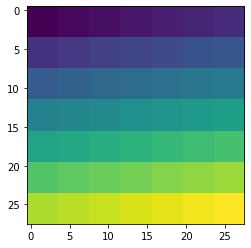

In [26]:
segments = superpixel(x_train[0])
plt.imshow(segments)

Each presented square is a superpixel. You can change the code above to test out other ways of determining superpixels. You could even just simply change the size from 4,4 to a different size and see what happens.

In [27]:
# Create an explainer object using AnchorImage that explains the mnist_nn model you created.
# Make sure to use the superpixel function as the segmentation function 

mnist_explainer = AnchorImage(superpixel, x_train[0].shape)
# raise NotImplementedError()

In [28]:
assert isinstance(mnist_explainer, AnchorImage)

In [29]:
# Change this number and try out different samples
image_index_to_explain = 2
image_to_explain = x_test.reshape(-1, 28, 28 ,1)[image_index_to_explain]

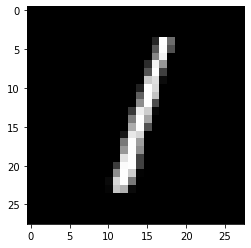

In [30]:
plt.imshow(image_to_explain[:,:,0], cmap="gray")

In [31]:
# Change the value of p_sample, and threshold here to see how the explanation changes based on the sample.
mnist_image_explanation = mnist_explainer.explain(image_to_explain, threshold=.9, p_sample=.5)

The model predicted the number as a 1 because of:


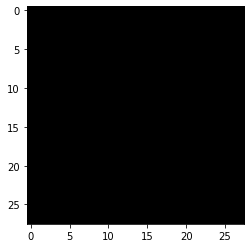

In [32]:
print(f"The model predicted the number as a {mnist_nn.predict(image_to_explain.reshape(1, 28, 28, 1)).argmax()} because of:")
plt.imshow(mnist_image_explanation.anchor[:,:,0], cmap="gray")

One thing you may have noticed is that the explanations are heavily dependent on the superpixels we identify. Have ideas for a better superpixel definition? Go back and try it!

## Explaining newsgroup predictions

With the newsgroup dataset we'll look at explaining how text gets predicted using [AnchorText](https://docs.seldon.io/projects/alibi/en/v0.2.2/methods/Anchors.html#Initialization).

In [33]:
from sklearn.datasets import fetch_20newsgroups
import spacy
from alibi.explainers import AnchorText
from alibi.utils.download import spacy_model
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
newsgroups = fetch_20newsgroups()

In [35]:
print(newsgroups["DESCR"])
text = newsgroups["data"]
news_labels = newsgroups["target"]
newsgroup_names = newsgroups["target_names"]

text_train, text_test, labels_train, labels_test = train_test_split(text, news_labels, random_state=0)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

In [36]:
# Creating a TFIDF vectorizer and Linear SVM classifier to make predictions about the newsgroup dataset

tfidf = TfidfVectorizer()
tfidf.fit(text_train)

clf = LinearSVC()
clf.fit(tfidf.transform(text_train), labels_train)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [37]:
# Create newsgroup_predictor which is a predictor function to use with an AnchorText predictor using
# the vectorizer and classifier defined in the cell above
# Note that you have to transform the data with the vectorizer and then predict it.

newsgroup_predictor = lambda text_train: clf.predict(tfidf.transform(text_train))
# raise NotImplementedError()

In [38]:
assert len(newsgroup_predictor(text_test[:2])) == 2

In [39]:
model = 'en_core_web_md'
spacy_model(model=model)
nlp = spacy.load(model)

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_md -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en_core_web_md
You can now load the model via spacy.load('en_core_web_md')


In [40]:
# Create the explainer to use
newsgroup_explainer = AnchorText(nlp, newsgroup_predictor)

In [41]:
# Copy the text of an article you find on the internet and save it as article

article = "Dance is a performing art form consisting of sequences of movement, either improvised or purposefully selected. This movement has aesthetic and often symbolic value. Dance can be categorized and described by its choreography, by its repertoire of movements, or by its historical period or place of origin. An important distinction is to be drawn between the contexts of theatrical and participatory dance, although these two categories are not always completely separate; both may have special functions, whether social, ceremonial, competitive, erotic, martial, or sacred/liturgical. Other forms of human movement are sometimes said to have a dance-like quality, including martial arts, gymnastics, cheerleading, figure skating, synchronised swimming, marching bands, and many other forms of athletics."
# raise NotImplementedError()

In [42]:
assert len(article) > 500

In [43]:
# Define article_explanation as the explainer's explanation for the article you provided.

article_explanation = newsgroup_explainer.explain(article)
# raise NotImplementedError()

In [44]:
print(f"The model predicted the article as {newsgroup_names[newsgroup_predictor([article])[0]]} because of the word: {article_explanation.anchor}")

The model predicted the article as talk.politics.mideast because of the word: ['said', 'movements', 'historical', 'its', 'many', 'by', 'movement', 'Other', 'movement', 'drawn', 'and', 'cheerleading']


In [45]:
# Change this number and try out different samples
test_sample_index = 28
test_sample = text_test[test_sample_index]
print(test_sample)

From: harmon@math.ohio-state.edu (Jim Harmon)
Subject: MIDI Keyboard $225
Organization: Department of Mathematics, The Ohio State University
Lines: 13
Distribution: cmh
NNTP-Posting-Host: ford.mps.ohio-state.edu


Roland HS-60 (SynthPlus 60)
  - 6 voice polyphonic fully programmable analog synthesizer
  - 61 full size keys
  - MIDI
  - Memory to store 128 patches
  - built in speakers
  - Connectors: MIDI in thru out, Input(2), Expansion Pedal, Head Phones,
    Tape Load & Save, Patch Shift, Pedal Hold, Output(2)

Asking $225
  
harmon@mps.ohio-state.edu



In [2]:
# test_sample_explanation = newsgroup_explainer.explain(test_sample)

In [4]:
# print(f"The model predicted the test sample as {newsgroup_names[newsgroup_predictor([test_sample])[0]]} because of the word {test_sample_explanation.anchor}")

## Feedback

In [5]:
def feedback():
    """Provide feedback on the contents of this exercise
    
    Returns:
        string
    """
    return("not too easy and not too difficult")
    # raise NotImplementedError()